### Table of contents

- [GPU Architecture](#gpu-architecture)
- [Triton: Scheduling Language](#triton-scheduling-language)
    - [Vector Addition](#vector-addition)
- [Tools](#tools)
    - [Nvidia Compute Sanitizer](#nvidia-compute-sanitizer)

In [35]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.33 s (started: 2025-10-23 18:24:01 +00:00)


### GPU Architecture

In [1]:
import torch
torch.cuda.is_available()

True

#### Name and properties

In [2]:
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Compute Capability:", torch.cuda.get_device_capability(0))
    print("GPU Memory Total (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))
    print("Current Device:", torch.cuda.current_device())

GPU Name: Tesla T4
GPU Compute Capability: (7, 5)
GPU Memory Total (GB): 15.83
Current Device: 0


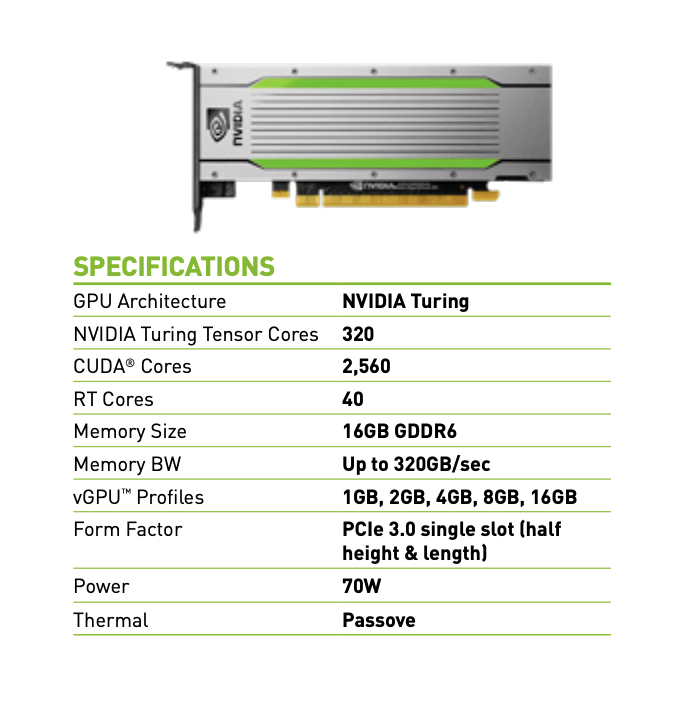
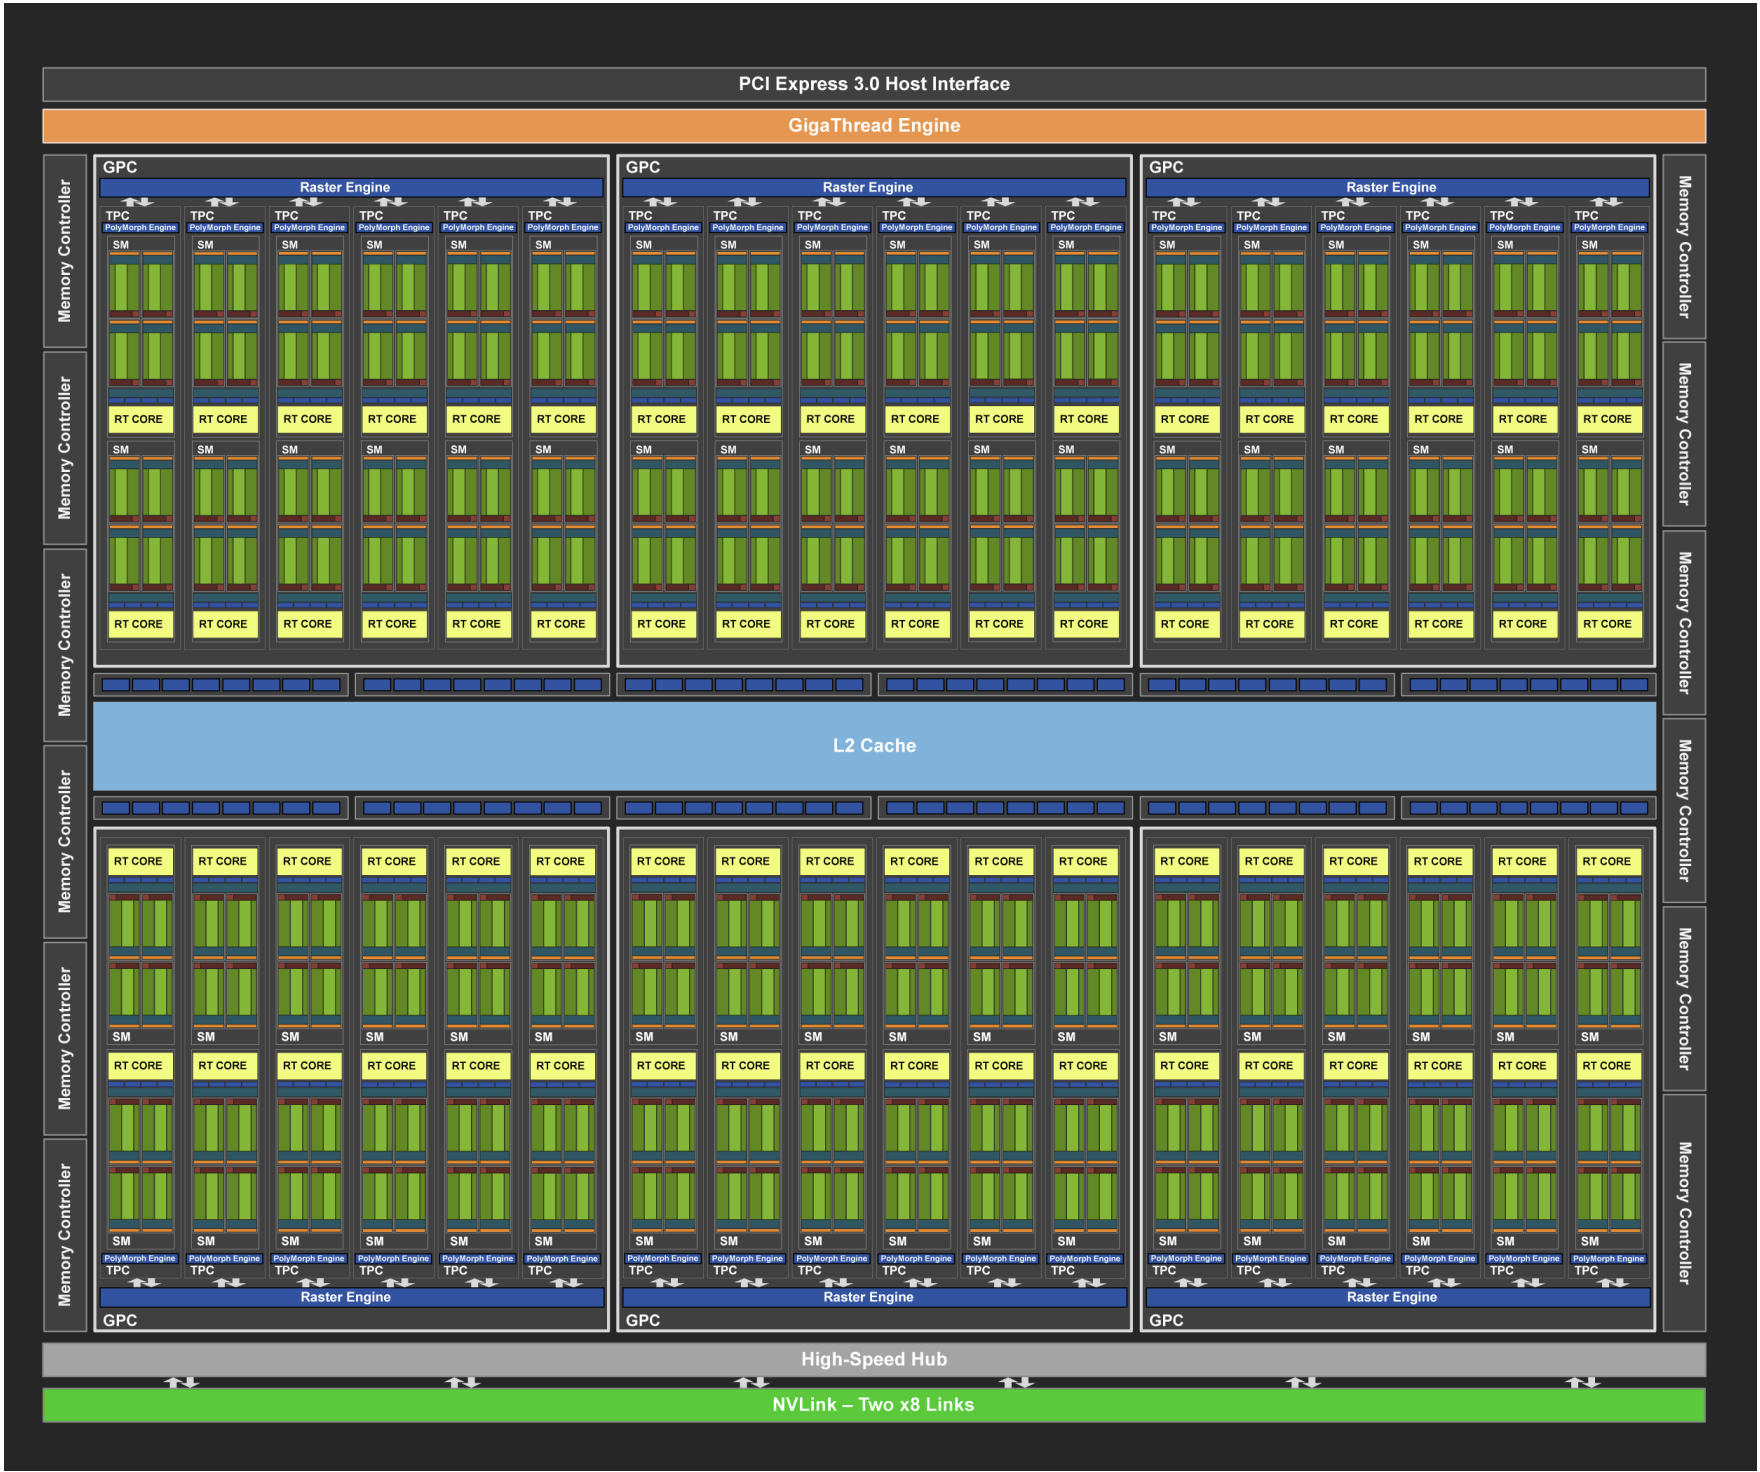
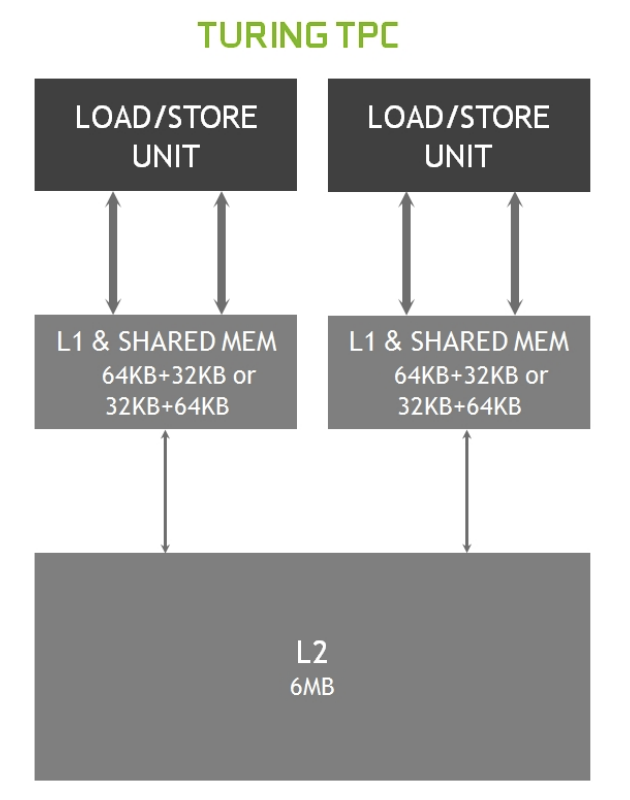

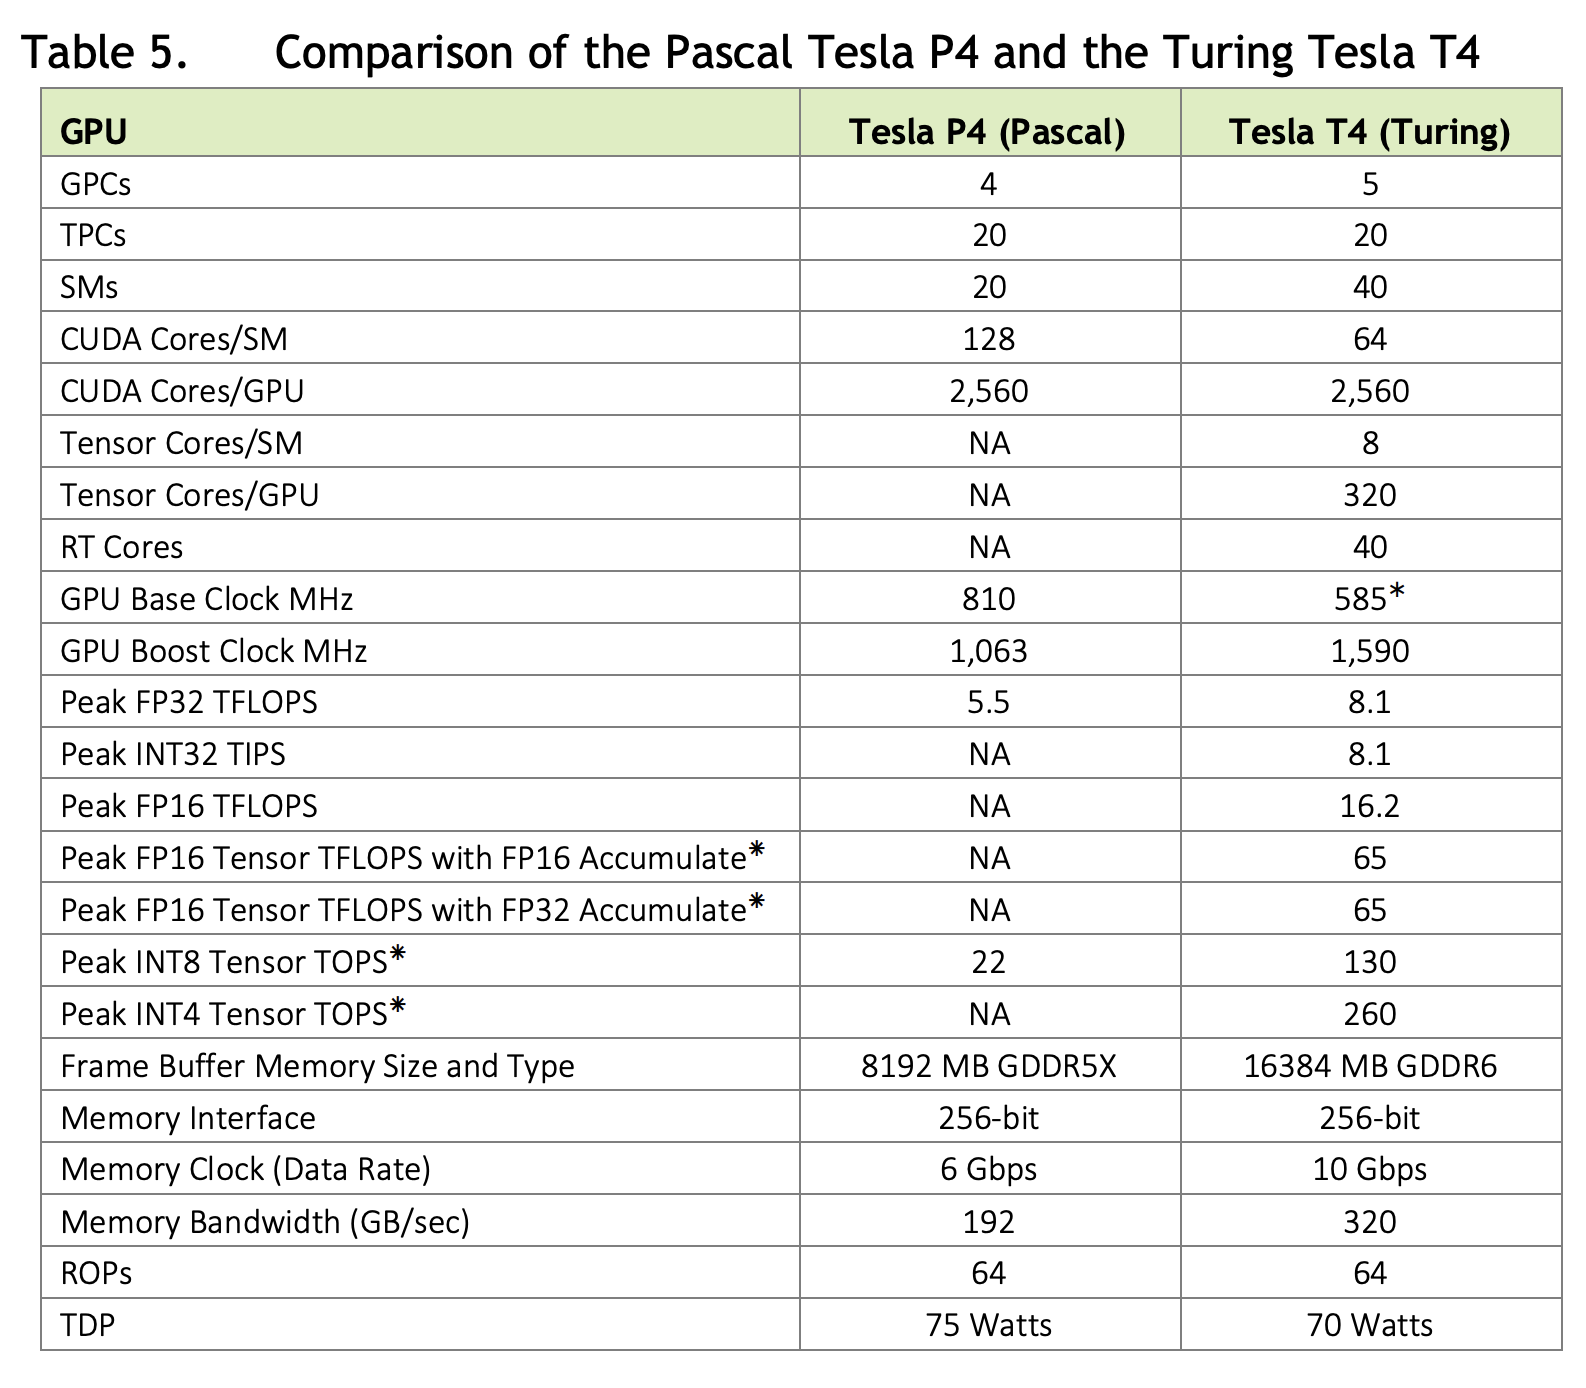

#### Streaming multi-processor

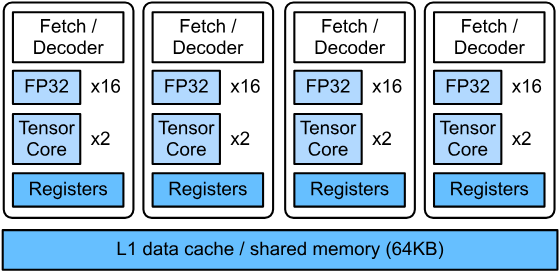

As can be seen, an SM is partitioned into 4 processing blocks. In each block, there are 16 arithmetic units (AU) for processing float32 numbers, which are also called FP32 CUDA cores. In total, an SM has 64 FP32 AUs, which are able to execute 64 float32 operators (e.g. FMA) in each time. Besides the register files and the instruction loader/decoders, an SM has 8 tensor cores. Each tensor core is able to execute a  4×4
  float16 (or int8/int4) matrix product in each time. So each one, we can call it FP16 AU, counts for  2×43=128
  operators per clock. It is worth noting that in this chapter we won’t use the tensor core. We will talk about utilizing it in the later chapter.

Another difference is that the SM only has an L1 cache, which is similar to CPU’s L1 cache. However, we can use this storage as a shared memory for all threads running on the SM. We know that the cache is controlled by both hardware and operating system, while we can explicitly allocate and reclaim space on the shared memory, which gives us more flexibility to do performance optimization.

##### Architecture

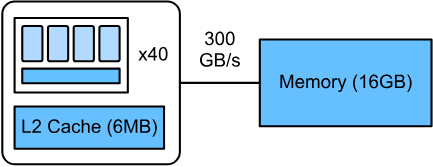

Tesla T4 card contains 40 SMs with a 6MB L2 cache shared by all SMs. It also ships with 16GB high-bandwidth memory (GDDR6) that is connected to the processor. 

Reference:

1. https://tvm.d2l.ai/chapter_gpu_schedules/arch.html

In [48]:
def get_gpu_memory(device=0, unit='MB'):
    import torch

    if not torch.cuda.is_available():
        return 0.0
    
    props = torch.cuda.get_device_properties(device)
    reserved = torch.cuda.memory_reserved(device)
    allocated = torch.cuda.memory_allocated(device)

    total = props.total_memory

    return {
        'total': total / (1024 ** 2),
        'free': (total - reserved - allocated) / (1024 ** 2)
    }

get_gpu_memory()

{'total': 15095.0625, 'free': -8563.02978515625}

time: 5.19 ms (started: 2025-10-23 18:28:18 +00:00)


### Triton: Scheduling Language

#### Install Triton related modules

In [6]:
!pip install triton


In [7]:
import triton as tr
tr.__version__

'3.4.0'

#### Triton Programming Model

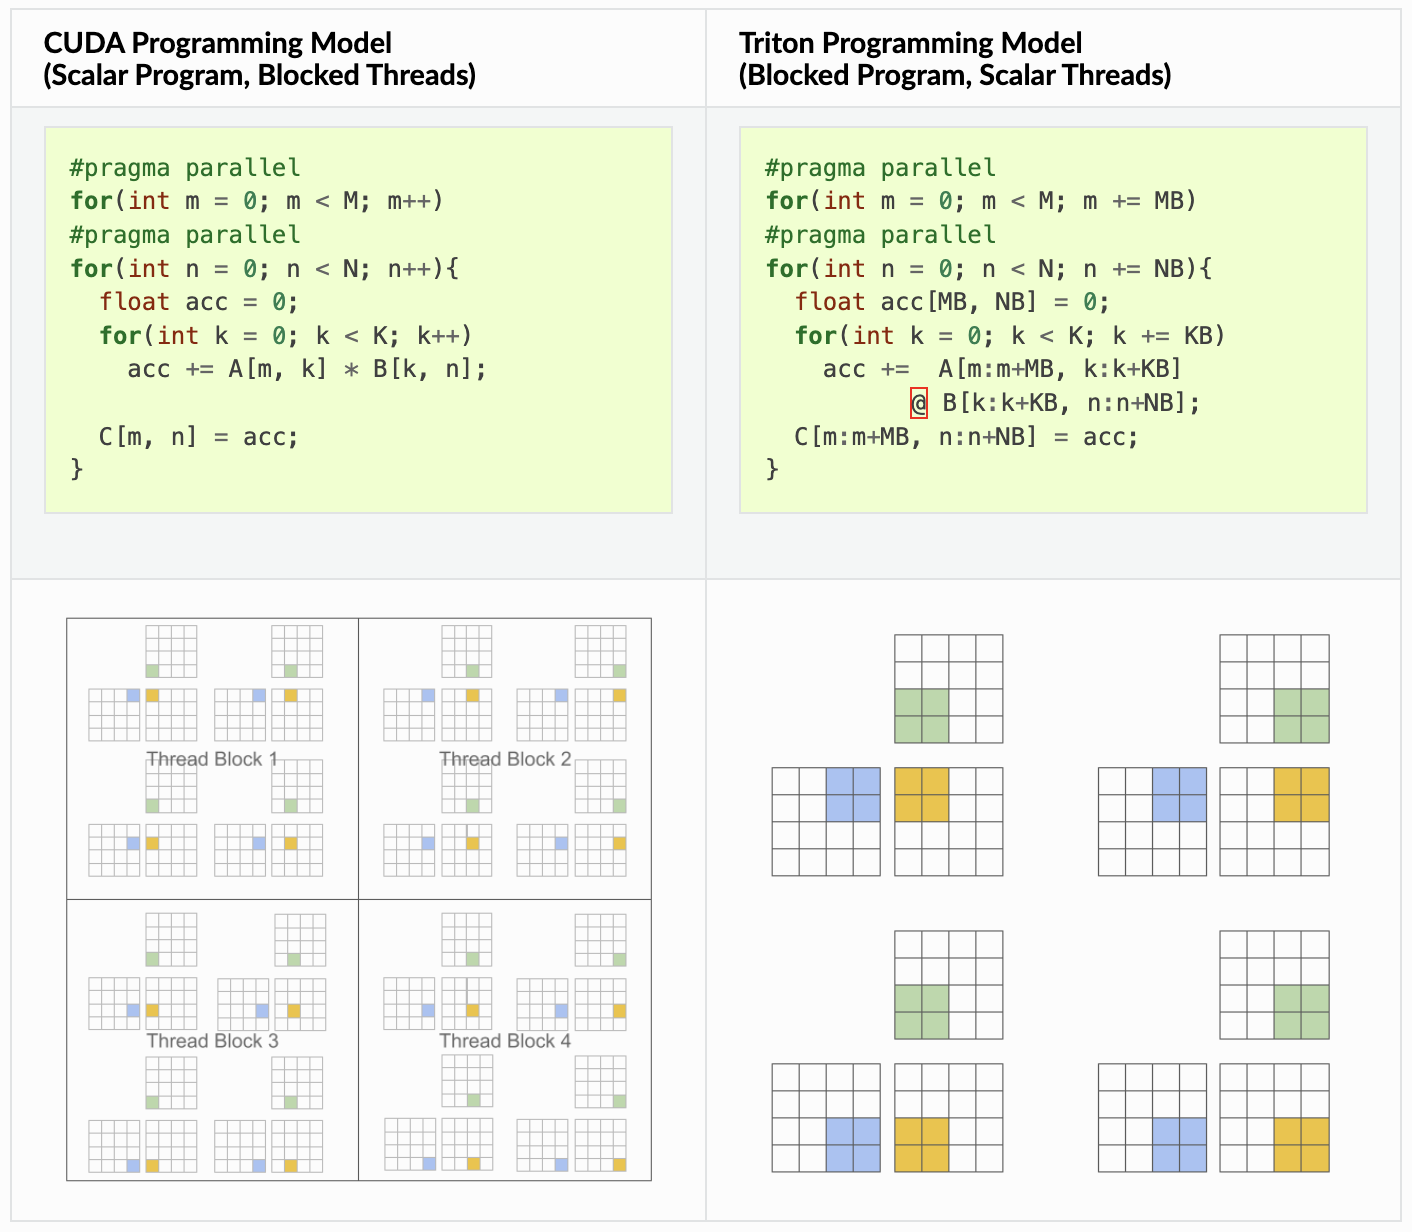

#### Vector Addition

In [36]:
def add(
    x1: torch.Tensor, x2: torch.Tensor, DEVICE
):
    import torch

    import triton as tr
    import triton.language as trl

    output = torch.empty_like(x1)
    assert x1.device == DEVICE and x2.device == DEVICE
    assert output.device == DEVICE

    number_total_elements = output.numel()

    # number of kernel instances that can be run in parallel, here equal to blocksize
    grid = lambda meta: (triton.cdiv(output.numel(), meta['BLOCK_SIZE']), )

    @triton.jit
    def add_kernel(
        ptr_y,
        ptr_x,
        ptr_output,
        number_total_elements,
        BLOCK_SIZE: trl.constexpr
    ):
        program_id = trl.program_id(axis=0)

        block_start = program_id * BLOCK_SIZE
        offsets = block_start + trl.arange(0, BLOCK_SIZE)
        # mask
        mask = offsets < number_total_elements
        x = trl.load(ptr_x + offsets, mask=mask)
        y = trl.load(ptr_y + offsets, mask=mask)
        # add
        output = x + y
        # write output back to DRAM.
        trl.store(ptr_output + offsets, output, mask=mask)

    add_kernel[grid](x, y, output, number_total_elements, BLOCK_SIZE=1024)

    return output

time: 2.19 ms (started: 2025-10-23 18:24:11 +00:00)


In [44]:
import triton; DEVICE = triton.runtime.driver.active.get_active_torch_device(); DEVICE

torch.manual_seed(1374)

size = 1_000_000_000
x, y = torch.ones(size, device=DEVICE), torch.ones(size, device=DEVICE)

output_torch = x + y
output_triton = add(x, y, DEVICE)
# print(output_torch); print(output_triton)

assert torch.allclose(output_torch, output_triton, 10e-3), "not close enough"

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.73 GiB. GPU 0 has a total capacity of 14.74 GiB of which 3.07 GiB is free. Process 50490 has 11.67 GiB memory in use. Of the allocated memory 11.55 GiB is allocated by PyTorch, and 5.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

time: 275 ms (started: 2025-10-23 18:24:57 +00:00)


In [64]:
!nvidia-smi --gpu-reset -i 0

GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.
time: 105 ms (started: 2025-10-23 18:33:38 +00:00)


In [62]:

def free_gpu_memory():
    import torch
    import gc
    import triton
    import triton.language as tl

    gc.collect()
    
    torch.cuda.memory.empty_cache()
    torch.cuda.ipc_collect()
    
    try:
        runtime.lazy_proxy.allocator.free_all_blocks()
        # triton.runtime.driver.cudart.cudaDeviceReset()
    except Exception as e:
        print(f"(Skipped Triton cleanup: {e})")

    torch.cuda.synchronize()
    print(f"✅ GPU memory cleared. Allocated: {torch.cuda.memory_allocated()/1e6:.2f} MB | Reserved: {torch.cuda.memory_reserved()/1e6:.2f} MB")

free_gpu_memory()
get_gpu_memory()

(Skipped Triton cleanup: name 'runtime' is not defined)
✅ GPU memory cleared. Allocated: 12400.56 MB | Reserved: 12406.75 MB


{'total': 15095.0625, 'free': -8563.02978515625}

time: 126 ms (started: 2025-10-23 18:33:25 +00:00)


In [65]:
import traceback
import sys

traceback.clear_frames(sys.exc_info()[2])

time: 531 µs (started: 2025-10-23 18:34:10 +00:00)


In [66]:
get_gpu_memory()

{'total': 15095.0625, 'free': -8563.02978515625}

time: 6.87 ms (started: 2025-10-23 18:34:15 +00:00)


In [74]:
!nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv

pid, process_name, used_gpu_memory [MiB]
50490, [Not Found], 11948 MiB
time: 109 ms (started: 2025-10-23 18:41:57 +00:00)


### Tools

In [78]:
!kill -9 50490
!nvidia-smi

import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
torch.cuda.synchronize()

!nvidia-smi


/bin/bash: line 1: kill: (50490) - No such process
Thu Oct 23 18:42:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P0             31W /   70W |   11950MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A

In [79]:
!nvidia-smi --gpu-reset -i 0


GPU 00000000:00:04.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.
time: 105 ms (started: 2025-10-23 18:43:04 +00:00)


#### Nvidia Compute Sanitizer

Compute Sanitizer is a functional correctness checking suite included in the CUDA toolkit. This suite contains multiple tools that can perform different type of checks. The memcheck tool is capable of precisely detecting and attributing out of bounds and misaligned memory access errors in CUDA applications. The tool can also report hardware exceptions encountered by the GPU. The racecheck tool can report shared memory data access hazards that can cause data races. The initcheck tool can report cases where the GPU performs uninitialized accesses to global memory. The synccheck tool can report cases where the application is attempting invalid usages of synchronization primitives. This document describes the usage of these tools.

https://docs.nvidia.com/compute-sanitizer/index.html